In [1]:
# Bryce Testing

In [104]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix

In [106]:
v1 = pd.read_parquet('[2015, 2016]_game_stats.parquet.gzip')
v2 = pd.read_parquet('[2017, 2018]_game_stats.parquet.gzip')
v3 = pd.read_parquet('[2019, 2020]_game_stats.parquet.gzip')
v4 = pd.read_parquet('[2021, 2022]_game_stats.parquet.gzip')
season_reg = pd.concat([v1, v2, v3, v4], axis = 0)
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()

In [107]:
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=int)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)

In [108]:
#create a dictionary with season team and per list 
seasons_pers = pd.read_csv('seasons_per_s.csv')

def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float16(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

rosters = get_top_n_pers(seasons_pers, 10)  # rosters[season][team]

In [109]:
# pipeline 
def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-04'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    return season

def run_pca(season= '2019-20'):
    season = get_season(season)
    pca = PCA(n_components=30)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    numeric_components = pca.fit(season_numeric)
    return pca 

def pre_process(season, pca, data_all):
    season_name = season
    season = get_season(season)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float64)
    spread = np.int8(season_numeric["home_pts"] - season_numeric["away_pts"])
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        for index, row in season_categorical.iterrows():
            # print(row[1], row[2], row[3])
            home_team.append(team_encoder.encode(row.iloc[1]))
            away_team.append(team_encoder.encode(row.iloc[2]))
            arena.append(arena_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = 10
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[1]])
            away_pers.append(rosters[prior_season_name][row.iloc[2]])

        
        return {'home_per_input': tf.convert_to_tensor(home_pers[:-1]),
       'home_team_input': tf.convert_to_tensor(home_team[:-1]),
       'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena[:-1]),
       'away_team_input': tf.convert_to_tensor(away_team[:-1]),
       'away_per_input': tf.convert_to_tensor(away_pers[:-1])}, tf.convert_to_tensor(spread[1:])
    else:
        return numeric_components[:-1], spread[1:]

In [7]:
pca = run_pca('2015-16')

# x_2020, y_2020= pre_process('2019-20', pca, data_all=False)
# x_2021, y_2021= pre_process('2020-21', pca, data_all=False)

x_2016, y_2016= pre_process('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process('2016-17', pca, data_all=True)

In [8]:
# regression model 
games = [1, 2, 3, 4, 5, 6] #games remove last game 
scores = [1 ,2, 3, 4, 5, 6] #scores remove 1st score 
games[:-1]
scores[1:]

[2, 3, 4, 5, 6]

In [29]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
output = tf.keras.layers.Dense(1, activation="linear")(h5)

# Create the model
bigger_model = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy", "mean_squared_error"])

# Print the model summary
bigger_model.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         26 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,383 (407.75 KB)

 Trainable params: 104,383 (407.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = bigger_model.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0091 - loss: 179.3045 - mean_squared_error: 179.2948 - val_accuracy: 0.0147 - val_loss: 184.6730 - val_mean_squared_error: 183.2184
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0141 - loss: 174.0284 - mean_squared_error: 174.0799 - val_accuracy: 0.0147 - val_loss: 184.2257 - val_mean_squared_error: 182.8267
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0094 - loss: 178.2506 - mean_squared_error: 178.2131 - val_accuracy: 0.0147 - val_loss: 184.7617 - val_mean_squared_error: 183.5804
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0085 - loss: 173.8261 - mean_squared_error: 173.7859 - val_accuracy: 0.0147 - val_loss: 186.5185 - val_mean_squared_error: 185.6236
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0097 - loss: 172.6160 - mean_squared_error: 172.6059 - val_accuracy: 0.0059 - val_loss: 185.5338 - val_mean_squared_error: 184.2541
Epoch 6/10
25/25 ━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


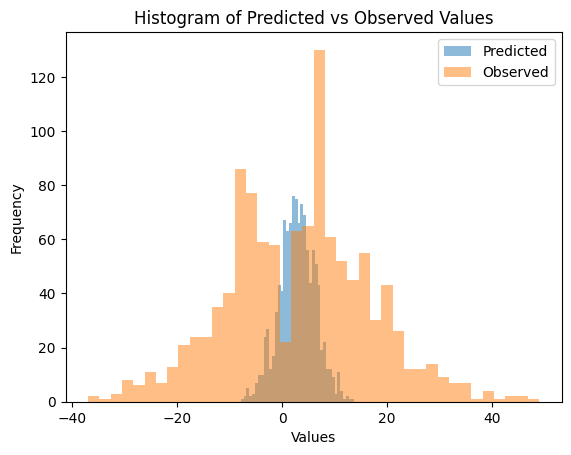

In [31]:
import matplotlib.pyplot as plt

predictions = pd.DataFrame(bigger_model.predict(x_2017).flatten())

predicted_values = predictions
observed_values = y_2017


# Plot histogram
plt.hist(predicted_values, bins=40, label='Predicted', alpha=0.5)
plt.hist(observed_values, bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted vs Observed Values')
plt.legend()
plt.show()

In [32]:
# classification - moneyline 
def get_moneyline(y_data):
    y_ml = pd.DataFrame(y_data.numpy())
    outcomes = []
    for index, row in y_ml.iterrows(): 
        if row[0] > 0: #win
            outcomes.append(np.int8([1, 0]))
        else:
            outcomes.append(np.int8([0, 1]))
    return tf.convert_to_tensor(outcomes)

In [102]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(150, activation="relu")(h1)
h3 = tf.keras.layers.Dense(150, activation="relu")(h2)
h4 = tf.keras.layers.Dense(100, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
output = tf.keras.layers.Dense(2, activation="softmax")(h5)

# Create the model
bigger_model_c = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model_c.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# Print the model summary
# bigger_model_c.summary()
tf.keras.backend.clear_session()

In [35]:
history = bigger_model_c.fit(x=x_2016,
    y=get_moneyline(y_2016), epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5723 - loss: 0.8657 - val_accuracy: 0.5894 - val_loss: 0.6839
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5950 - loss: 0.6727 - val_accuracy: 0.5806 - val_loss: 0.6824
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6657 - val_accuracy: 0.5894 - val_loss: 0.7118
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6008 - loss: 0.6559 - val_accuracy: 0.5836 - val_loss: 0.6981
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6033 - loss: 0.6523 - val_accuracy: 0.5425 - val_loss: 0.6932
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6774 - loss: 0.6297 - val_accuracy: 0.4985 - val_loss: 0.7080
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6210 - loss: 0.6504 - val_accuracy: 0.5982 - val_loss: 0.7262
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6768 - loss: 0.5859 - val_accuracy: 0.5279 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


(array([669.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 467.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

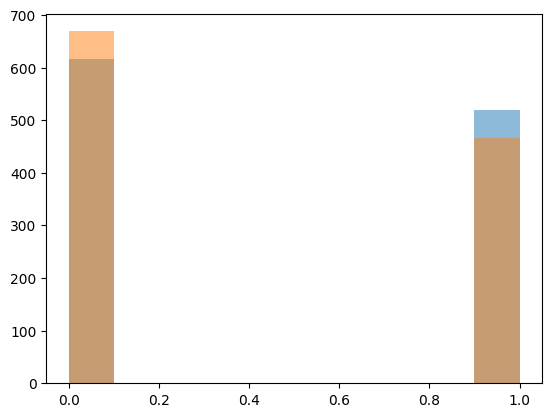

In [49]:
predictions = pd.DataFrame(bigger_model_c.predict(x_2016))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(get_moneyline(y_2016).numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


(array([664.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 475.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

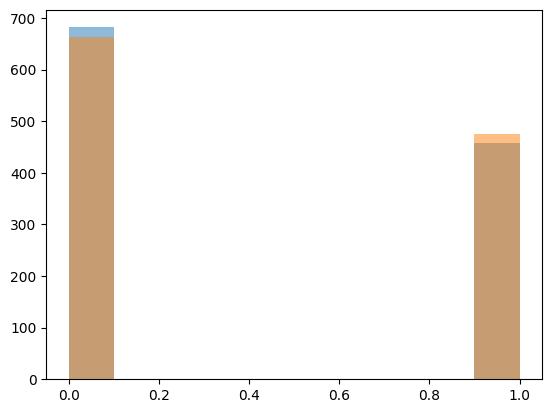

In [50]:
predictions = pd.DataFrame(bigger_model_c.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(get_moneyline(y_2017).numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

In [111]:
# trying moneyline oh team preds 
def pre_process_oh(season, pca, data_all):
    season_name = season
    season = get_season(season)
    # shuffles data
    season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    #drop cloumns to perform pca 
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    numeric_components = np.array(pca.transform(season_numeric), dtype=np.float64)
    spread = np.int8(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    if data_all == True:
        # one hot encoded teams
        home_team = []
        away_team = []
        arena = []
        home_pers = []
        away_pers = []
        winner = []
        for index, row in alt_season.iterrows():
            home_team.append(team_encoder.encode(row.iloc[0]))
            away_team.append(team_encoder.encode(row.iloc[1]))
            arena.append(arena_encoder.encode(row.iloc[2]))
            winner.append(team_encoder.encode(row.iloc[3]))
            # get top n player pers
            top_n = 10
            if season_name == '2014-15':
                raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
            else: 
                start = int(season_name[0:4])-1
                end = int(season_name[-2:])-1
                prior_season_name = f'{start}-{end}'
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])

        
        return {'home_per_input': tf.convert_to_tensor(home_pers[:-1]),
       'home_team_input': tf.convert_to_tensor(home_team[:-1]),
       'season_pca_input': tf.convert_to_tensor(numeric_components[:-1]),
       'arena_input': tf.convert_to_tensor(arena[:-1]),
       'away_team_input': tf.convert_to_tensor(away_team[:-1]),
       'away_per_input': tf.convert_to_tensor(away_pers[:-1])},  tf.convert_to_tensor(winner[1:])
    else:
        return numeric_components[:-1], spread[1:]

In [85]:
x_2016, y_2016= pre_process_oh('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process_oh('2016-17', pca, data_all=True)

In [93]:
# Define input layers for each input
home_per_input = tf.keras.Input(shape=(10,), name='home_per_input')
home_team_input = tf.keras.Input(shape=(30,), name='home_team_input')
season_pca_input = tf.keras.Input(shape=(30,), name='season_pca_input')
arena_input = tf.keras.Input(shape=(51,), name='arena_input')
away_team_input = tf.keras.Input(shape=(30,), name='away_team_input')
away_per_input = tf.keras.Input(shape=(10,), name='away_per_input')

# Concatenate or merge the inputs
concatenated_inputs = tf.keras.layers.concatenate([home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input])

# Define the rest of your model architecture
h1 = tf.keras.layers.Dense(161, activation="relu")(concatenated_inputs)
h2 = tf.keras.layers.Dense(200, activation="relu")(h1)
h3 = tf.keras.layers.Dense(200, activation="relu")(h2)
h4 = tf.keras.layers.Dense(25, activation="relu")(h3)
h5 = tf.keras.layers.Dense(25, activation="relu")(h4)
concatenated_teams = tf.keras.layers.concatenate([home_team_input, h5, away_team_input])
output = tf.keras.layers.Dense(30, activation="softmax")(concatenated_teams )

# Create the model
bigger_model_m_oh = tf.keras.Model(inputs=[home_per_input, home_team_input, season_pca_input, arena_input, away_team_input, away_per_input], outputs=output)

# Compile the model
bigger_model_m_oh.compile(loss=categorical_crossentropy, optimizer="adam", metrics=["accuracy"])

# Print the model summary
bigger_model_m_oh.summary()
tf.keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_pca_input    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_per_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 161)       │          0 │ home_per_input[0… │
│ (Concatenate)       │                   │            │ home_team_input[… │
│                     │                   │            │ season_pca_input… │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ away_team_input[… │
│                     │                   │            │ away_per_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 161)       │     26,082 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     32,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      5,025 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │        650 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 85)        │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_4[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30)        │      2,580 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,937 (417.72 KB)

 Trainable params: 106,937 (417.72 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = bigger_model_m_oh.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0157 - loss: 3.4473 - val_accuracy: 0.0469 - val_loss: 3.4216
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0650 - loss: 3.3787 - val_accuracy: 0.0352 - val_loss: 3.4089
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0570 - loss: 3.3605 - val_accuracy: 0.0499 - val_loss: 3.3849
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0979 - loss: 3.3148 - val_accuracy: 0.0411 - val_loss: 3.3806
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0935 - loss: 3.2822 - val_accuracy: 0.0528 - val_loss: 3.3822
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1168 - loss: 3.2063 - val_accuracy: 0.0528 - val_loss: 3.3561
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1295 - loss: 3.1820 - val_accuracy: 0.0645 - val_loss: 3.3972
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0992 - loss: 3.1754 - val_accuracy: 0.0528 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


(array([106., 102., 114., 118., 122., 129., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

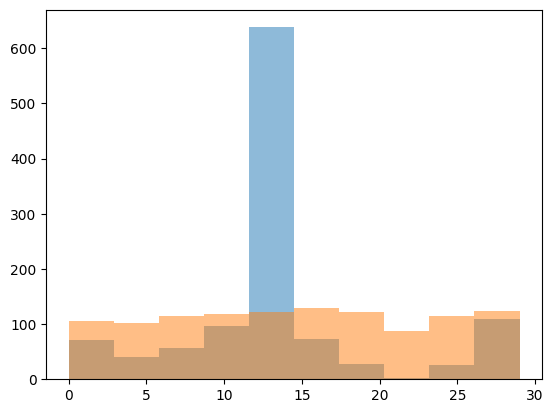

In [125]:
predictions = pd.DataFrame(bigger_model_m_oh.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017.numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')

In [112]:
#shuffling training data to see how it affects results

In [114]:
x_2016, y_2016= pre_process_oh('2015-16', pca, data_all=True)
x_2017, y_2017= pre_process_oh('2016-17', pca, data_all=True)

In [115]:
history = bigger_model_m_oh.fit(x=x_2016,
    y=y_2016, epochs=10, validation_split = 0.3)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0444 - loss: 3.4072 - val_accuracy: 0.0440 - val_loss: 3.3903
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0666 - loss: 3.3632 - val_accuracy: 0.0557 - val_loss: 3.3843
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0474 - loss: 3.3217 - val_accuracy: 0.0557 - val_loss: 3.3825
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0699 - loss: 3.3198 - val_accuracy: 0.0587 - val_loss: 3.4070
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0858 - loss: 3.2474 - val_accuracy: 0.0499 - val_loss: 3.4645
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0874 - loss: 3.2518 - val_accuracy: 0.0557 - val_loss: 3.4306
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0873 - loss: 3.2194 - val_accuracy: 0.0557 - val_loss: 3.4405
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0977 - loss: 3.1697 - val_accuracy: 0.0528 - val_loss:

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(array([106., 102., 114., 118., 122., 129., 122.,  87., 115., 124.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

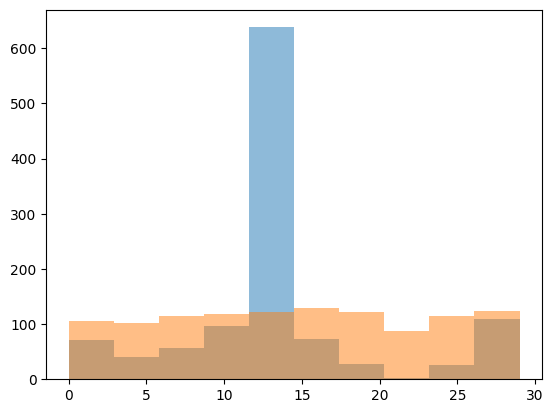

In [126]:
predictions = pd.DataFrame(bigger_model_m_oh.predict(x_2017))
predictions = np.argmax(predictions.to_numpy(), axis = 1)
plt.hist(predictions, alpha=0.5, label='preds')
observed = np.argmax(y_2017.numpy(),  axis =1)
plt.hist(observed, alpha=0.5, label='obser')